In [27]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1706000118.3307664
Tue Jan 23 08:55:18 2024


Quanvolutional Neural Networks {#quanvolution}
==============================

::: {.meta}
:property=\"og:description\": Train a quantum convolutional neural
network to classify MNIST images. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//circuit.png>
:::

*Author: Andrea Mari --- Posted: 24 March 2020. Last updated: 15 January
2021.*

In this demo we implement the *Quanvolutional Neural Network*, a quantum
machine learning model originally introduced in [Henderson et al.
(2019)](https://arxiv.org/abs/1904.04767).

![](../_static/demonstration_assets/quanvolution/circuit.png){.align-center
width="90.0%"}

Introduction
------------

### Classical convolution

The *convolutional neural network* (CNN) is a standard model in
classical machine learning which is particularly suitable for processing
images. The model is based on the idea of a *convolution layer* where,
instead of processing the full input data with a global function, a
local convolution is applied.

If the input is an image, small local regions are sequentially processed
with the same kernel. The results obtained for each region are usually
associated to different channels of a single output pixel. The union of
all the output pixels produces a new image-like object, which can be
further processed by additional layers.

### Quantum convolution

One can extend the same idea also to the context of quantum variational
circuits. A possible approach is given by the following procedure which
is very similar to the one used in Ref. \[1\]. The scheme is also
represented in the figure at the top of this tutorial.

1.  A small region of the input image, in our example a $2 \times 2$
    square, is embedded into a quantum circuit. In this demo, this is
    achieved with parametrized rotations applied to the qubits
    initialized in the ground state.
2.  A quantum computation, associated to a unitary $U$, is performed on
    the system. The unitary could be generated by a variational quantum
    circuit or, more simply, by a random circuit as proposed in Ref.
    \[1\].
3.  The quantum system is finally measured, obtaining a list of
    classical expectation values. The measurement results could also be
    classically post-processed as proposed in Ref. \[1\] but, for
    simplicity, in this demo we directly use the raw expectation values.
4.  Analogously to a classical convolution layer, each expectation value
    is mapped to a different channel of a single output pixel.
5.  Iterating the same procedure over different regions, one can scan
    the full input image, producing an output object which will be
    structured as a multi-channel image.
6.  The quantum convolution can be followed by further quantum layers or
    by classical layers.

The main difference with respect to a classical convolution is that a
quantum circuit can generate highly complex kernels whose computation
could be, at least in principle, classically intractable.

::: {.note}
::: {.title}
Note
:::

In this tutorial we follow the approach of Ref. \[1\] in which a fixed
non-trainable quantum circuit is used as a \"quanvolution\" kernel,
while the subsequent classical layers are trained for the classification
problem of interest. However, by leveraging the ability of PennyLane to
evaluate gradients of quantum circuits, the quantum kernel could also be
trained.
:::

General setup
-------------

This Python code requires *PennyLane* with the *TensorFlow* interface
and the plotting library *matplotlib*.


In [28]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model
=================================================


In [29]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/quanvolution"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset
============================

We import the MNIST dataset from *Keras*. To speedup the evaluation of
this demo we use only a small number of training and test images.
Obviously, better results are achievable when using the full dataset.


In [30]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Quantum circuit as a convolution kernel
=======================================

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


In [31]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

::: {.note}
::: {.title}
Note
:::

This process halves the resolution of the input image. In the standard
language of CNN, this would correspond to a convolution with a
$2 \times 2$ *kernel* and a *stride* equal to $2$.
:::


In [32]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum pre-processing of the dataset
=====================================

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.


In [33]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


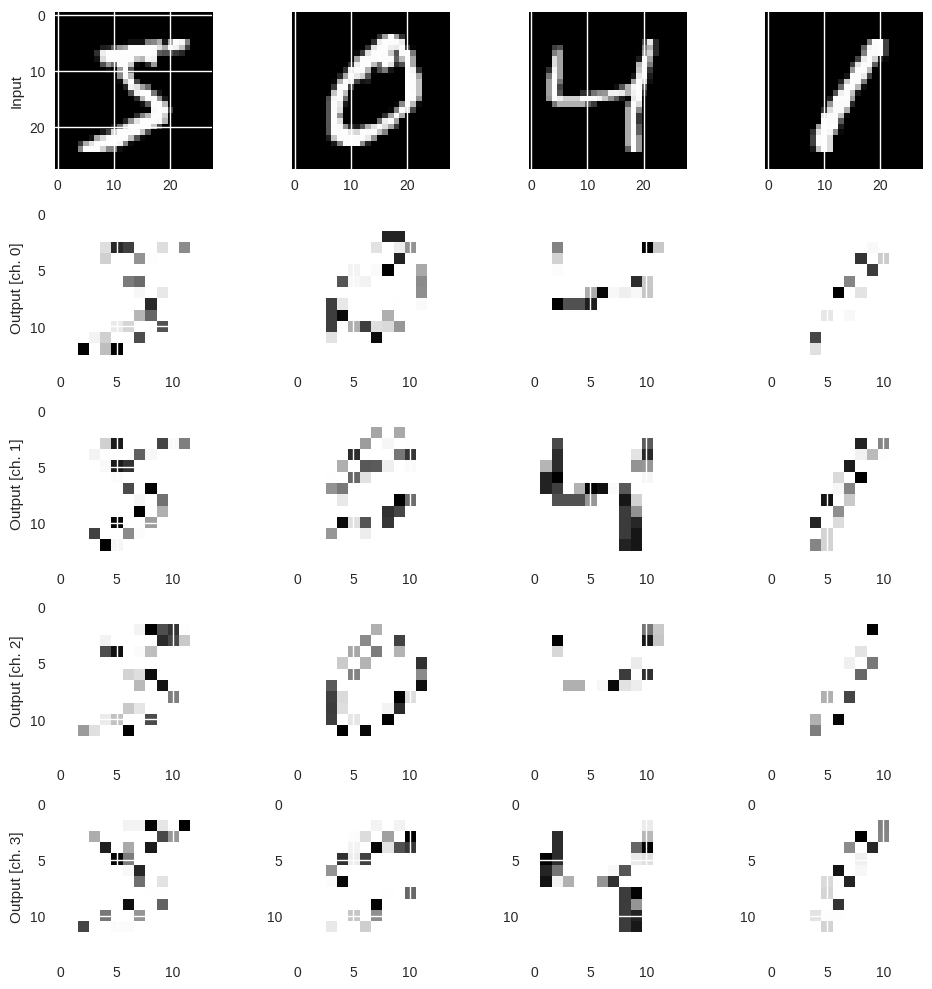

In [34]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


Hybrid quantum-classical model
==============================

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [35]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [36]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 3.1497 - accuracy: 0.0800 - val_loss: 2.4975 - val_accuracy: 0.0333 - 1s/epoch - 77ms/step
Epoch 2/30
13/13 - 0s - loss: 2.4949 - accuracy: 0.1800 - val_loss: 2.4020 - val_accuracy: 0.1667 - 59ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 2.3435 - accuracy: 0.1800 - val_loss: 2.4355 - val_accuracy: 0.1000 - 58ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.9775 - accuracy: 0.3000 - val_loss: 2.3018 - val_accuracy: 0.1667 - 59ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.9126 - accuracy: 0.3800 - val_loss: 2.2700 - val_accuracy: 0.1333 - 59ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.7907 - accuracy: 0.3600 - val_loss: 2.3897 - val_accuracy: 0.1000 - 58ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 1.5564 - accuracy: 0.5200 - val_loss: 2.1725 - val_accuracy: 0.3000 - 59ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 1.4456 - accuracy: 0.6200 - val_loss: 2.2610 - val_accuracy: 0.1333 - 56ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s - l

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [37]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4174 - accuracy: 0.0800 - val_loss: 2.0614 - val_accuracy: 0.3000 - 591ms/epoch - 45ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0223 - accuracy: 0.2800 - val_loss: 1.9271 - val_accuracy: 0.4333 - 57ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7162 - accuracy: 0.5600 - val_loss: 1.8124 - val_accuracy: 0.4667 - 59ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4844 - accuracy: 0.7600 - val_loss: 1.6963 - val_accuracy: 0.5667 - 59ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2820 - accuracy: 0.8200 - val_loss: 1.5844 - val_accuracy: 0.6333 - 56ms/epoch - 4ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1197 - accuracy: 0.8800 - val_loss: 1.4951 - val_accuracy: 0.6333 - 58ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9770 - accuracy: 0.9400 - val_loss: 1.4278 - val_accuracy: 0.6667 - 56ms/epoch - 4ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8568 - accuracy: 0.9600 - val_loss: 1.3636 - val_accuracy: 0.7333 - 58ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


<ipython-input-38-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


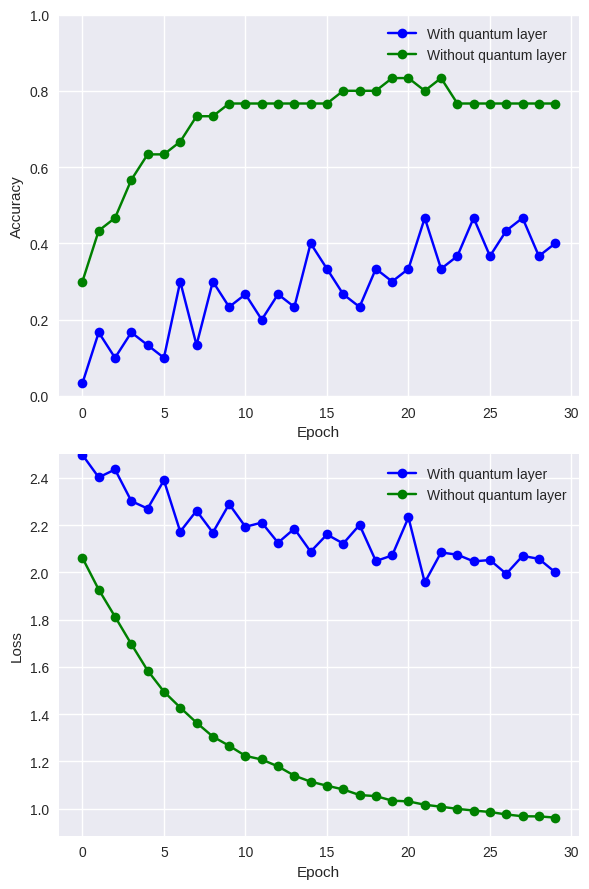

In [38]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

About the author
================


In [39]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1706000238.575018
Tue Jan 23 08:57:18 2024
